In [10]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms, datasets
import torch

from classifiers.NerveNet import NerveNET, BinaryOut
from data_utils_NerveNet import SegmentationData
from solver_NerveNet import Solver
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

import run_length_encoder as rle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
img_files = 'test_files.txt' 

In [12]:
input_dim = (1, 128, 128)

test_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])

test_data = SegmentationData(img_files, transform = test_transforms, mode = 'all', shuffle = False)

test_data.eval_mode()

In [13]:
model = torch.load("models/NerveNet_binary_iGAN.model", map_location=lambda storage, loc: storage)

In [14]:
org_size = (420, 580) 
def enlarge(img, shape = org_size):
    img = img.data.type('torch.FloatTensor')
    img = tu.ToPILImage()(img)
    img = tu.Resize(shape)(img)
    return np.array(img)
    

In [15]:
lt = len(test_data)
with open('submission_NerveNet_binary_iGAN.csv', 'w') as file:
    file.write('img,pixels\n')
    for img_no, inputs in enumerate(tqdm(test_data)):
        
        inputs = Variable(inputs).unsqueeze(0)
        if model.is_cuda:
            inputs = inputs.cuda()

        outputs = model.forward(inputs)
        pred = outputs['main']
        _, pred = torch.max(pred, 1)
        _, binary = torch.max(outputs['binary'], 1)

        #Comment/Uncomment to compare with and without binary classification
        if binary.data.numpy() == 0:
            pred = pred * 0

        pred = enlarge(pred)
        pred_rle = rle.encode(pred, thresh = 254)
        
        file.write('%s,'%(img_no+1) + ' '.join([str(x) for x in pred_rle]) + '\n') 
    

100%|██████████| 5508/5508 [1:11:57<00:00,  1.28it/s]


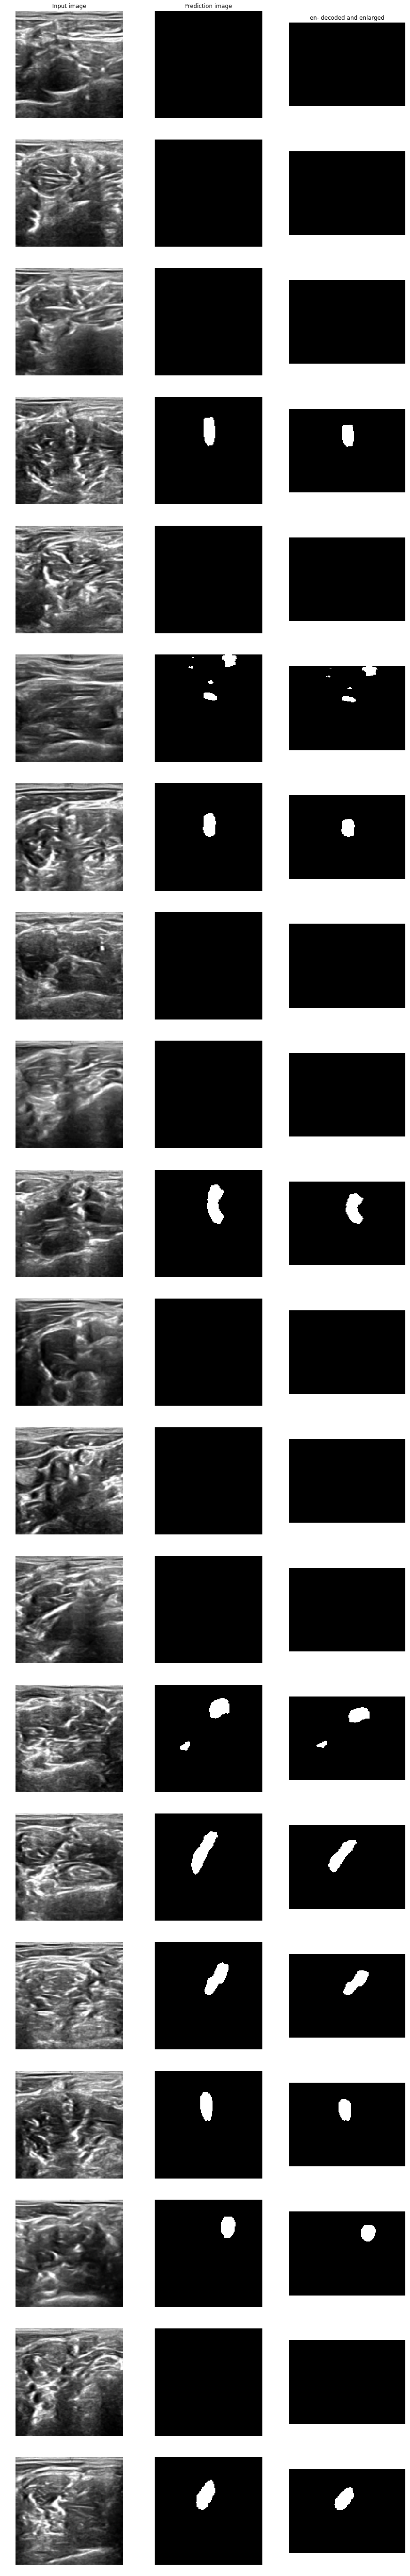

In [278]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, img in enumerate(test_data[20:40]):
    
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred_rle = rle.decode(rle.encode(enlarge(pred), thresh = 200))
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
            
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
        
    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
        
    # en- decoded and enlarged image
        # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred_rle, cmap='gray')
    if i == 0:
        plt.title("en- decoded and enlarged")
    
plt.show()

In [7]:
with open('submission_NerveNet_binary_iGAN.csv', 'r') as f:
    with open('submission_NerveNet_binary_iGAN_temp.csv', 'w') as g:
        g.write('img,pixels\n')
        lines = f.readlines()
        newlines = []
        for i, l in enumerate(lines[1::]):
            idx = l.find(',')
            newlines.append('%s'%(i+1) + l[idx::])
        g.writelines(newlines)